In [ ]:
import torch
class Relu(torch.nn.Module):
    def __init__(self):
        # Chiamata alla superclasse
        super(Relu, self).__init__()

    def forward(self, x):
        return torch.nn.functional.relu(x)

In [ ]:
import torch
class Linear(torch.nn.Module):
    def __init__(self, in_features=None, output_features=None):
        super(Linear, self).__init__()
        self.output_features = output_features
        self.in_features = in_features
        self.W = torch.nn.Parameter(data=torch.rand(size=(self.in_features, output_features)).cuda())
        torch.nn.init.xavier_normal(self.W)
    def forward(self, x):
        return torch.matmul(x.reshape(x.shape[0], x.shape[1],-1), self.W)  # + self.b

    def __repr__(self):
        return "Linear(in_features = " + str(self.in_features) + " out_features = " + str(self.output_features) + ")"

In [ ]:
class BatchNorm1D(torch.nn.BatchNorm1d):
  def __init__(self, num_features, eps=1e-5, momentum=0.1,
                affine=True, track_running_stats=True):
      super(BatchNorm1D, self).__init__(
          num_features, eps, momentum, affine, track_running_stats)
      self.stability = 1e-05
      # Scale and shifting parameters
      self.gamma = torch.ones(num_features, requires_grad=True)
      self.beta = torch.zeros(num_features, requires_grad=True)
      self.eps = eps
      self.momentum = momentum

  def forward(self, x):
      # calculate running estimates
      if self.training:
          mean = x.mean([0, 2, 3])
          # use biased var in train
          var = x.var([0, 2, 3], unbiased=False)
          n = x.numel() / x.size(1)
          with torch.no_grad():
              self.running_mean = self.momentum * mean + (1 - self.momentum) * self.running_mean
              # update running_var with unbiased var
              self.running_var = self.momentum * var * n / (n - 1)\
                  + (1 - self.momentum) * self.running_var
      else:
          mean = self.running_mean
          var = self.running_var

      # Scale and shift
      x = (x - mean[None, :, None, None]) / (torch.sqrt(var[None, :, None, None] + self.eps))
      return x * self.gamma[None,:,None,None] + self.beta[None, :, None, None]

In [ ]:
import torch.nn

class VAE(torch.nn.Module):
    def __init__(self,input_shape,channels,h_dim,z_dim):
        super(VAE,self).__init__()
        #Encoder, image to hidden space
        self.encode_input_batch = BatchNorm1D(channels,eps=1e-3).cuda()
        self.img_2hid = Linear(input_shape,h_dim).cuda()
        self.fc_mu,self.fc_std = Linear(h_dim,z_dim).cuda(),Linear(h_dim,z_dim).cuda()
        self.norm_mu,self.norm_std = BatchNorm1D(channels,eps=1e-3).cuda(),BatchNorm1D(channels,eps=1e-3).cuda()
        # The decoder from the z space goes back to the hidden
        self.z_2hidden = Linear(z_dim,h_dim).cuda()
        self.hidden_batch_norm = BatchNorm1D(channels,eps=1e-3).cuda()
        # Finally from the hidden we go back to the input space
        self.hidden_2img = Linear(h_dim,input_shape).cuda()
        self.img_batch = BatchNorm1D(channels,eps=1e-3).cuda()
        self.relu = Relu().cuda()
        self.rloss = torch.nn.MSELoss(reduction="sum").cuda()


    def encode(self,x):
        x_first_en = self.img_2hid(x)
        #Normalize
        x_norm = self.encode_input_batch(x_first_en)
        x_rel = self.relu(x_norm)
        mu_fc,sigma_fc = self.fc_mu(x_rel),self.fc_std(x_rel)
        mu_norm,sigma_norm = self.norm_mu(mu_fc),self.norm_std(sigma_fc)
        mu,sigma = self.relu(mu_norm),self.relu(sigma_norm)
        if torch.all(torch.isnan(mu)) or torch.all(torch.isnan(sigma)):
          torch.save({
              'x': x,
              'x_norm': x_norm,
              'mu_fc': mu_fc,
              'sigma_fc': sigma_fc,
              'mu_norm': mu_norm,
              'sigma_norm': sigma_norm,
              'mu': mu,
              'sigma': sigma
          },'drive/MyDrive/DataVAE/errorlog/encode_error.pt')
          raise OverflowError

        return mu,sigma

    def decode(self,x):
        x_tohidden = self.z_2hidden(x)
        x_norm = self.hidden_batch_norm(x_tohidden)
        x_lrelu = torch.nn.functional.leaky_relu(x_norm)
        x_img = self.hidden_2img(x_lrelu)
        x_imgnorm = self.img_batch(x_img)
        x_imgrel = self.relu(x_imgnorm)
        if torch.all(torch.isnan(x_imgrel)):
          torch.save({
              'x': x,
              'x_tohidden': x_tohidden,
              'x_norm': x_norm,
              'x_lrelu': x_lrelu,
              'x_img': x_img,
              'x_imgnorm': x_imgnorm,
              'x_imgrel': x_imgrel
          },'drive/MyDrive/DataVAE/errorlog/decode_error.pt')
          raise OverflowError
        return x_imgrel

    def normalize(self,x):
        v_min, v_max = x.min(), x.max()
        new_min, new_max = torch.Tensor([0]).float().to('cuda:0'), torch.Tensor([1]).float().to('cuda:0')
        out = torch.add(torch.mul(torch.div(torch.sub(x, v_min), torch.sub(v_max, v_min)), torch.sub(new_max, new_min)),new_min)
        if torch.all(torch.isnan(out)):
          torch.save({
              'x': x,
              'v_min': v_min,
              'v_max': v_max,
              'new_min': new_min,
              'new_max': new_max,
              'out': out,
          },'drive/MyDrive/DataVAE/errorlog/norm_error.pt')
          raise OverflowError
        return out


    def forward(self,x):
        original = x.shape
        mu, sigma = self.encode(x)
        normal = torch.distributions.Normal(0,1)
        # Sample from latent distribution from encoder std = torch.exp(torch.log(sigma) / 2 )
        epsilon = torch.randn_like(sigma)
        z = mu + sigma.exp() * epsilon
        if torch.all(torch.isnan(z)):
          torch.save({
              'x': x,
              'mu': mu,
              'sigma': sigma,
              'simga.exp()': sigma.exp(),
              'epsilon': epsilon,
              'z': z,
          },'drive/MyDrive/DataVAE/errorlog/forward_error.pt')
          raise OverflowError
        x_hat = self.normalize(self.decode(z)).reshape(original)
        log_q = torch.sum(normal.log_prob(epsilon) - sigma)
        recon_error = self.rloss(x_hat,x)
        elbo = recon_error - log_q
        return elbo,recon_error,x_hat



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

def load_data(batch,data_dir="./content/drive/MyDrive/DataVAE/data"):

    trainset = torchvision.datasets.MNIST(
        root=data_dir, split='train', download=True,transform=transforms.ToTensor())

    valset = torchvision.datasets.MNIST(
        root=data_dir, split='valid', download=True,transform=transforms.ToTensor())

    testset = torchvision.datasets.MNIST(
        root=data_dir, split='test', download=True,transform=transforms.ToTensor())

    # Partitioning the dataset in 80% train & 20% validation
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])
    trainloader = torchvision.datasets.CelebA(
        train_subset, batch_size=batch, shuffle=True, num_workers=4
    )

    valloader = torchvision.datasets.CelebA(
        val_subset, batch_size=12000 , shuffle=True, num_workers=4
    )

    testloader = torchvision.datasets.CelebA(
        testset, batch_size=batch, shuffle=False, num_workers=4
    )

    return trainset,valset,testset

In [ ]:
####### FINAL TRAINIG WITH MNIST
import itertools
def build_hyper_params():
    epochs = [15]
    batch = [1000]
    hidden_features = [400]
    z_features = [100]
    lr = [1e-5]
    grad_clip = [2e-4]
    hyper_list = [epochs,batch,hidden_features,z_features,lr,grad_clip]
    return list(itertools.product(*hyper_list))


In [ ]:
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import torch


def load_data(batch,data_dir="./data"):

    trainset = torchvision.datasets.MNIST(
        root=data_dir, train=True, download=True,transform=transforms.ToTensor())

    testset = torchvision.datasets.MNIST(
        root=data_dir, train=False, download=True,transform=transforms.ToTensor())

    print(len(testset))

    trainloader = torch.utils.data.DataLoader(
          trainset, batch_size=batch, shuffle=True, num_workers=1
      )

    testloader = torch.utils.data.DataLoader(
          testset, batch_size=10000, shuffle=False, num_workers=1)

    return trainloader,testloader

In [ ]:
(15,1000,400,200,3e-2,2e-4) # Scelto dalla model selection per miglior ricostruzione
(15,1000,600,100,1e-05,2e-4) # Scelto dalla model selection per migliore loss di validazione
configs = [(15,1000,400,200,3e-2,2e-4),(15,1000,600,100,1e-05,2e-4)]

from tqdm import tqdm
configs = tqdm(configs)
for i,config in enumerate(configs):
  tr_loss_list,test_loss_list = [],[]
  tr_rec_list, test_rec_list = [], []
  epochs, batch, hidden_features, z_features, lr, grad_clip = config
  net = VAE(28*28,1,hidden_features,z_features)
  net.to('cuda:0')
  opt = torch.optim.Adam(net.parameters(),lr)

  #Load data
  trainset,testset = load_data(batch)
  tr_loss,val_loss = 0,0

  for epoch in range(epochs):
    # Train loop
    net.train()
    configs.set_postfix(Trying=config, Status='Training',Epoch=epoch)
    for i,data in enumerate(trainset):
            opt.zero_grad()
            x,labels = data
            x = x.to('cuda:0')
            tr_loss,tr_rec,_ = net(x)
            tr_loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(),lr)
            opt.step()

    # Save tr loss for the epoch
    tr_loss_list.append(tr_loss),tr_rec_list.append(tr_rec)


    # Save test loss for the epoch
    test_loss_list.append(test),test_rec_list.append(test_rec)

  # Save model & performance
  torch.save(net,'drive/MyDrive/DataVAE/models/model' + str(config) + '.pt')
  torch.save({
      'epoch': epoch,
      'config': config,
      'model_state_dict': net.state_dict(),
      'optimizer_state_dict': opt.state_dict(),
      'loss_list': tr_loss_list,
      'test_loss_list': test_loss_list,
      'tr_rec_list': tr_rec_list,
      'test_rec_list': test_rec_list
  },'drive/MyDrive/DataVAE/perf/model' + str(config) + 'perf.pt')

  #Test loop
  net.eval()
  for i,data in enumerate(testset):
    with torch.no_grad():
      x, labels = data
      x = x.to('cuda:0')
      test,test_rec,_ = net(x)



  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-14-a49f02dee571>:8: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(self.W)
  0%|          | 0/2 [00:00<?, ?it/s, Epoch=0, Status=Training, Trying=(15, 1000, 400, 200, 0.03, 0.0002)]

10000


 50%|█████     | 1/2 [02:00<02:00, 120.56s/it, Epoch=0, Status=Training, Trying=(15, 1000, 600, 100, 1e-05, 0.0002)]

10000


100%|██████████| 2/2 [04:03<00:00, 121.86s/it, Epoch=14, Status=Training, Trying=(15, 1000, 600, 100, 1e-05, 0.0002)]


310152.75 3111354.0
26381.353515625 272252.5


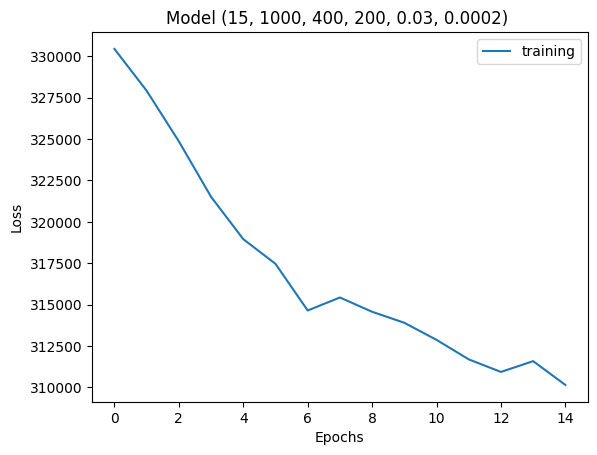

In [ ]:
import torch
import matplotlib.pyplot as plt
x = torch.load('/content/drive/MyDrive/DataVAE/perf/model(15, 1000, 400, 200, 0.03, 0.0002)perf.pt')
epoch = [y for y in range(15)]
loss,test = [ z.detach().item() for z in  x['loss_list']],[ k.detach().item()  for k in x['test_loss_list']]
r_loss,r_test = [ z.detach().item() for z in  x['tr_rec_list']],[ k.detach().item()  for k in x['test_rec_list']]
print(loss[-1],test[-1])
print(r_loss[-1],r_test[-1])
plt.plot(epoch,loss,label='training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model (15, 1000, 400, 200, 0.03, 0.0002) ')
plt.legend()

236763.359375 2387431.0
70727.78125 725964.625


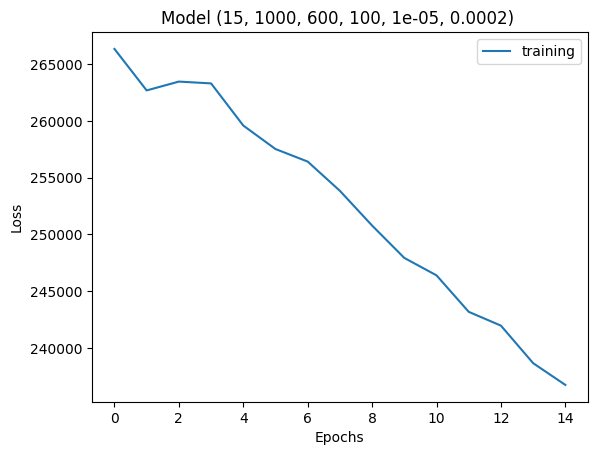

In [ ]:
import torch
x = torch.load('/content/drive/MyDrive/DataVAE/perf/model(15, 1000, 600, 100, 1e-05, 0.0002)perf.pt')
import matplotlib.pyplot as plt
epoch = [y for y in range(15)]
loss,test = [z.detach().item() for z in  x['loss_list']],[k.detach().item() for k in x['test_loss_list']]
r_loss,r_test = [ z.detach().item() for z in  x['tr_rec_list']],[ k.detach().item()  for k in x['test_rec_list']]
print(loss[-1],test[-1])
print(r_loss[-1],r_test[-1])
plt.plot(epoch,loss,label='training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model (15, 1000, 600, 100, 1e-05, 0.0002) ')
plt.legend()

10000


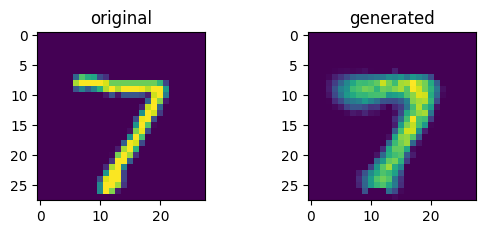

In [ ]:
###### Visualize how well the models do
net1 = torch.load('/content/drive/MyDrive/DataVAE/models/model(15, 1000, 400, 200, 0.03, 0.0002).pt')
net1.to('cuda:0')
net1.eval()
train,test = load_data(1)
inputs, classes = next(iter(test)) # Taking one sample
x = inputs[0,:,:,:].unsqueeze(0)
with torch.no_grad():
  x = x.to('cuda:0')
  loss,rec,img = net1(x)

plt.subplot(2, 2, 1) # n is the position of your subplot (1 to 4)
plt.title('original')
plt.imshow(x.cpu().squeeze(0).permute(1,2,0))
plt.subplot(2, 2, 2)
plt.title('generated')
plt.imshow(img.cpu().squeeze(0).permute(1,2,0))


10000


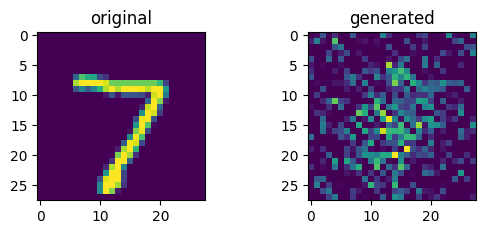

In [ ]:
###### Visualize how well the models do
net1 = torch.load('/content/drive/MyDrive/DataVAE/models/model(15, 1000, 600, 100, 1e-05, 0.0002).pt')
net1.to('cuda:0')
net1.eval()
train,test = load_data(1)
inputs, classes = next(iter(test)) # Taking one sample
x = inputs[0,:,:,:].unsqueeze(0)
with torch.no_grad():
  x = x.to('cuda:0')
  loss,rec,img = net1(x)

plt.subplot(2, 2, 1) # n is the position of your subplot (1 to 4)
plt.title('original')
plt.imshow(x.cpu().squeeze(0).permute(1,2,0))
plt.subplot(2, 2, 2)
plt.title('generated')
plt.imshow(img.cpu().squeeze(0).permute(1,2,0))